In [60]:
#Now with the Data Modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimpy as sk
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

#Metrics, Sampling and Etc.
from sklearn.preprocessing import(
    RobustScaler,
    PolynomialFeatures)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import(
    precision_recall_curve,
    precision_score,
    roc_curve,
    auc,
    f1_score, recall_score, roc_auc_score)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


#Models to be tested
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Imbalanced Data Splitting
from imblearn.over_sampling import SMOTE

#Model Export
import pickle

In [8]:
df = pd.read_csv("manila_landsat_data.csv", index_col=0)
df = df.drop(columns=["pixel_id", "row", "col"])
df

,B1_coastal,B2_blue,B3_green,B4_red,B5_nir,B6_swir1,B7_swir2,NDVI,NDBI,NDWI,SAVI,brightness,ratio_swir_nir,ratio_nir_red
0,8586,8700,9131,8971,9244,8195,8023,0.014988,3.697861,3.560435,0.022481,8803.333333,0.886521,1.030431
1,8197,8646,10138,9818,19031,14292,10833,0.319352,1.824476,1.941890,0.479020,14380.333333,0.750985,1.938378
2,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
3,7680,7773,7775,7615,7752,7935,7846,0.008915,0.011666,0.001481,0.013372,7767.333333,1.023607,1.017991
4,8164,8094,7827,7351,7183,7400,7449,4.497592,0.014880,0.042905,6.746156,7311.333333,1.030210,0.977146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
49996,8134,8100,7845,7327,7049,7250,7326,4.539371,0.014057,0.053444,6.808820,7208.666667,1.028515,0.962058
49997,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
49998,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN


In [9]:
#Applying Urban threshold
def create_urban_target(df):
    """
    Create binary urban target using multiple spectral criteria
    Urban areas typically have:
    - High NDBI (> 0.1)
    - Moderate to high brightness
    - Low to moderate NDVI (not vegetation)
    """
    # Define conditions for urban classification
    urban_conditions = (
        (df['NDBI'] > 0.1) &          # Primary urban indicator
        (df['brightness'] > np.percentile(df['brightness'], 50)) &  # Above median brightness
        (df['NDVI'] < 0.3)            # Not heavily vegetated
    )

    df['is_urban'] = urban_conditions.astype(int)
    return df

# Apply the multi-criteria approach
df = create_urban_target(df)

In [12]:
df["is_urban"].value_counts()
#i knew it, we need to imbalanced learning for this one since its an unbalanced dataset

,count
is_urban,
0,44327
1,5673


In [18]:
#Descriptive Statistics
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 50000  │ │ int64       │ 8     │                                                          │
│ │ Number of columns │ 15     │ │ float64     │ 7     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column          ┃ NA     ┃ NA %    ┃ mean   ┃ sd     ┃ p0     ┃ p25     ┃ p50    ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ B1_coastal      │      0 │       0 │   5538 │   3871 │      0 │       0 │   7631 │   8247 │ 24400 │  ▇█▆   │  │
│ │ B2_blue         │      0 │       0 │   5655 │   3966 │      0 │       0 │   7748 │   8316 │ 26660 │  ▅█▂   │  │
│ │ B3_green        │      0 │       0 │   6009 │   4278 │      0 │       0 │   7751 │   9134 │ 29400 │  ▅█▂   │  │
│ │ B4_red          │      0 │       0 │   5861 │   4255 │      0 │       0 │   7339 │   8672 │ 31850 │  ▄█▁   │  │
│ │ B5_nir          │      0 │       0 │   8850 │   7585 │      0 │       0 │   7274 │  16720 │ 34620 │  ██▄▅  │  │
│ │ B6_swir1        │      0 │       0 │   7539 │   6030 │      0 │       0 │   7446 │  12810 │ 33700 │  ██▇▁  │  │
│ │ B7_swir2        │      0 │       0 │   6469 │   4889 │      0 │       0 │   7475 │   9775 │ 39180 │  ▄█▁   │  │
│ │ NDVI            │  16071 │  32.142 │  1.364 │   1.87 │      0 │  0.1545 │ 0.3439 │  3.864 │  4.71 │ █    ▃ │  │
│ │ NDBI            │  16071 │  32.142 │   1.06 │  1.156 │      0 │ 0.01463 │ 0.0893 │  1.933 │ 23.22 │   █    │  │
│ │ NDWI            │  16071 │  32.142 │  1.275 │  1.128 │      0 │ 0.03561 │  1.824 │  2.147 │ 5.743 │  █▂█   │  │
│ │ SAVI            │      0 │       0 │  1.389 │  2.501 │      0 │       0 │ 0.2505 │ 0.6066 │ 7.065 │ █    ▂ │  │
│ │ brightness      │      0 │       0 │   7412 │   5795 │      0 │       0 │   7350 │  13200 │ 21760 │ █▁▇▇▂  │  │
│ │ ratio_swir_nir  │  16071 │  32.142 │ 0.9051 │ 0.1676 │ 0.4284 │  0.7434 │  1.004 │   1.03 │  1.89 │  ▂▃█   │  │
│ │ ratio_nir_red   │  16071 │  32.142 │  1.492 │  0.568 │ 0.6025 │  0.9959 │  1.292 │  1.992 │ 3.524 │ █▃▃▃▁  │  │
│ │ is_urban        │      0 │       0 │ 0.1135 │ 0.3172 │      0 │       0 │      0 │      0 │     1 │ █    ▁ │  │
│ └─────────────────┴────────┴─────────┴────────┴────────┴────────┴─────────┴────────┴────────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

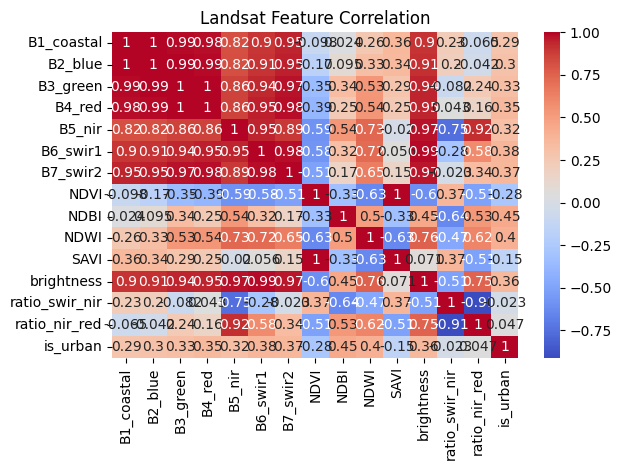

In [24]:
#Data Visualization
#Correlation
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.figsize=(20, 10)
plt.title("Landsat Feature Correlation")
plt.tight_layout()
#plt.savefig("Landsat Feature Correlation.png")
plt.show()


/tmp/ipython-input-2894345261.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")


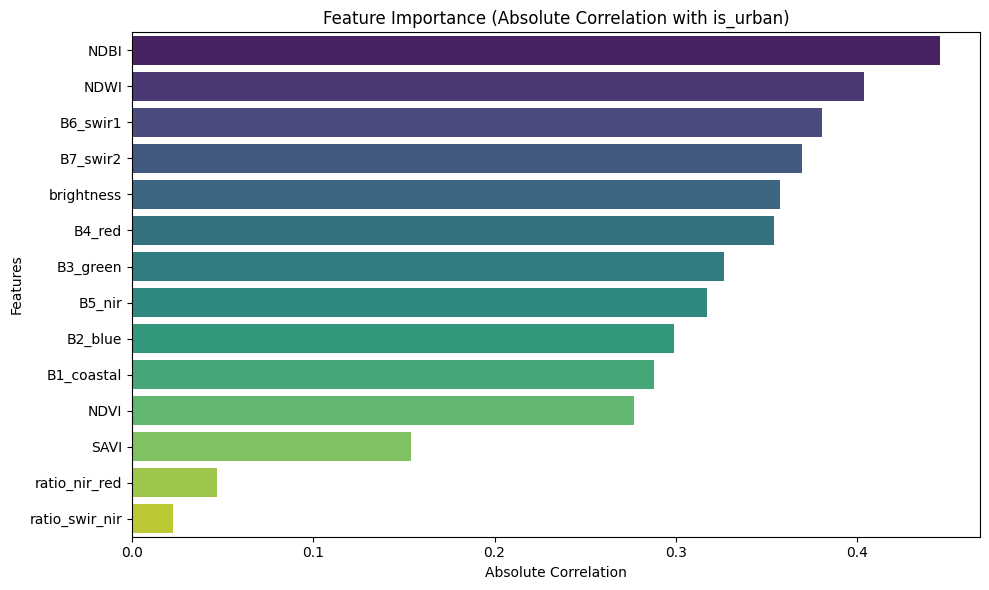

In [25]:
#Feature Importance
#Calculate the absolute correlation of each feature with the target variable 'is_urban'
feature_importance = df.corr()['is_urban'].abs().sort_values(ascending=False)

# Remove the correlation of 'is_urban' with itself
feature_importance = feature_importance.drop('is_urban')

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance (Absolute Correlation with is_urban)")
plt.xlabel("Absolute Correlation")
plt.ylabel("Features")
plt.tight_layout()
#plt.savefig("Feature Importance.png")
plt.show()

/tmp/ipython-input-1240642783.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='is_urban', y=feature, data=df, ax=axes[i],
/tmp/ipython-input-1240642783.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Non-Urban', 'Urban'])
/tmp/ipython-input-1240642783.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='is_urban', y=feature, data=df, ax=axes[i],
/tmp/ipython-input-1240642783.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Non-Urban', 'Urban'])
/tmp

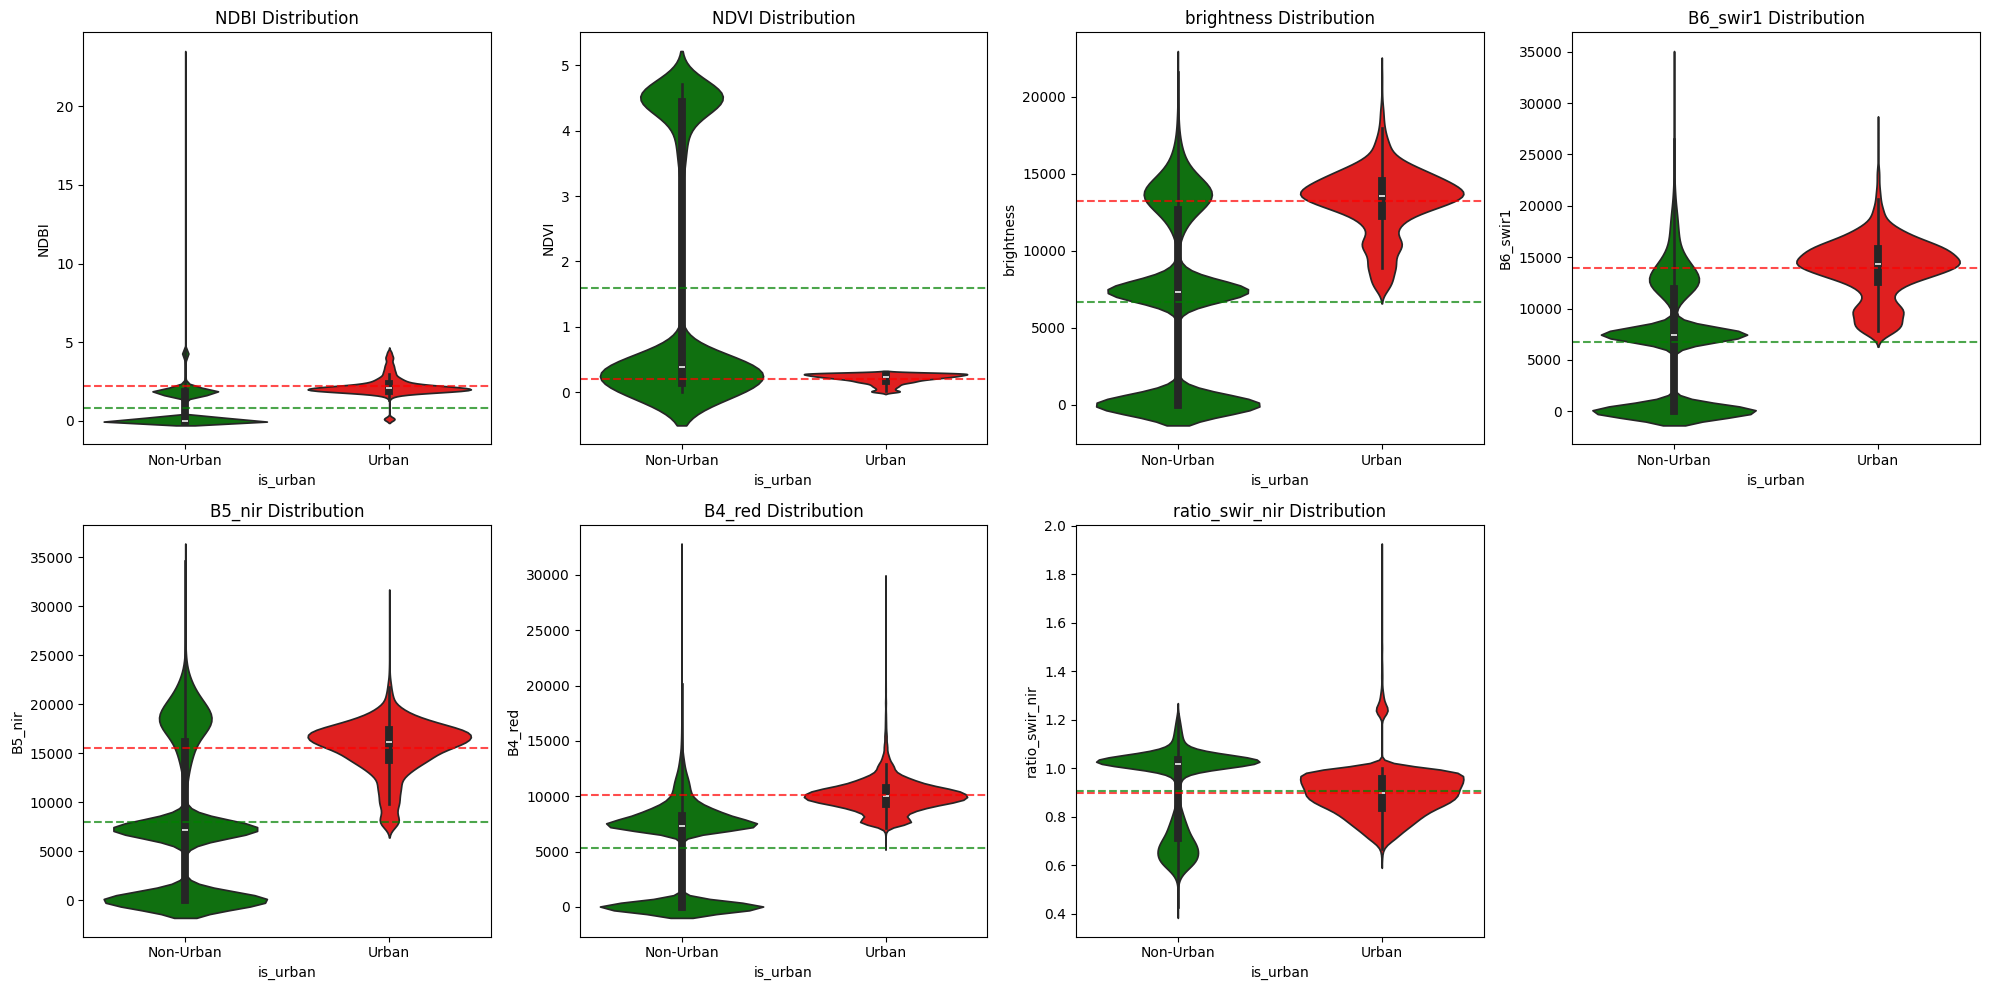

In [27]:
#Feature Distribution Per class
# Select key features for comparison
key_features = ['NDBI', 'NDVI', 'brightness', 'B6_swir1', 'B5_nir', 'B4_red', 'ratio_swir_nir']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    if i < len(axes):
        # Create violin plot
        sns.violinplot(x='is_urban', y=feature, data=df, ax=axes[i],
                       palette={'0': 'green', '1': 'red'})
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xticklabels(['Non-Urban', 'Urban'])

        # Add mean lines
        urban_mean = df[df['is_urban'] == 1][feature].mean()
        non_urban_mean = df[df['is_urban'] == 0][feature].mean()
        axes[i].axhline(urban_mean, color='red', linestyle='--', alpha=0.7)
        axes[i].axhline(non_urban_mean, color='green', linestyle='--', alpha=0.7)

# Remove empty subplots
for i in range(len(key_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig("Feature Distribution Per Class.png")
plt.show()

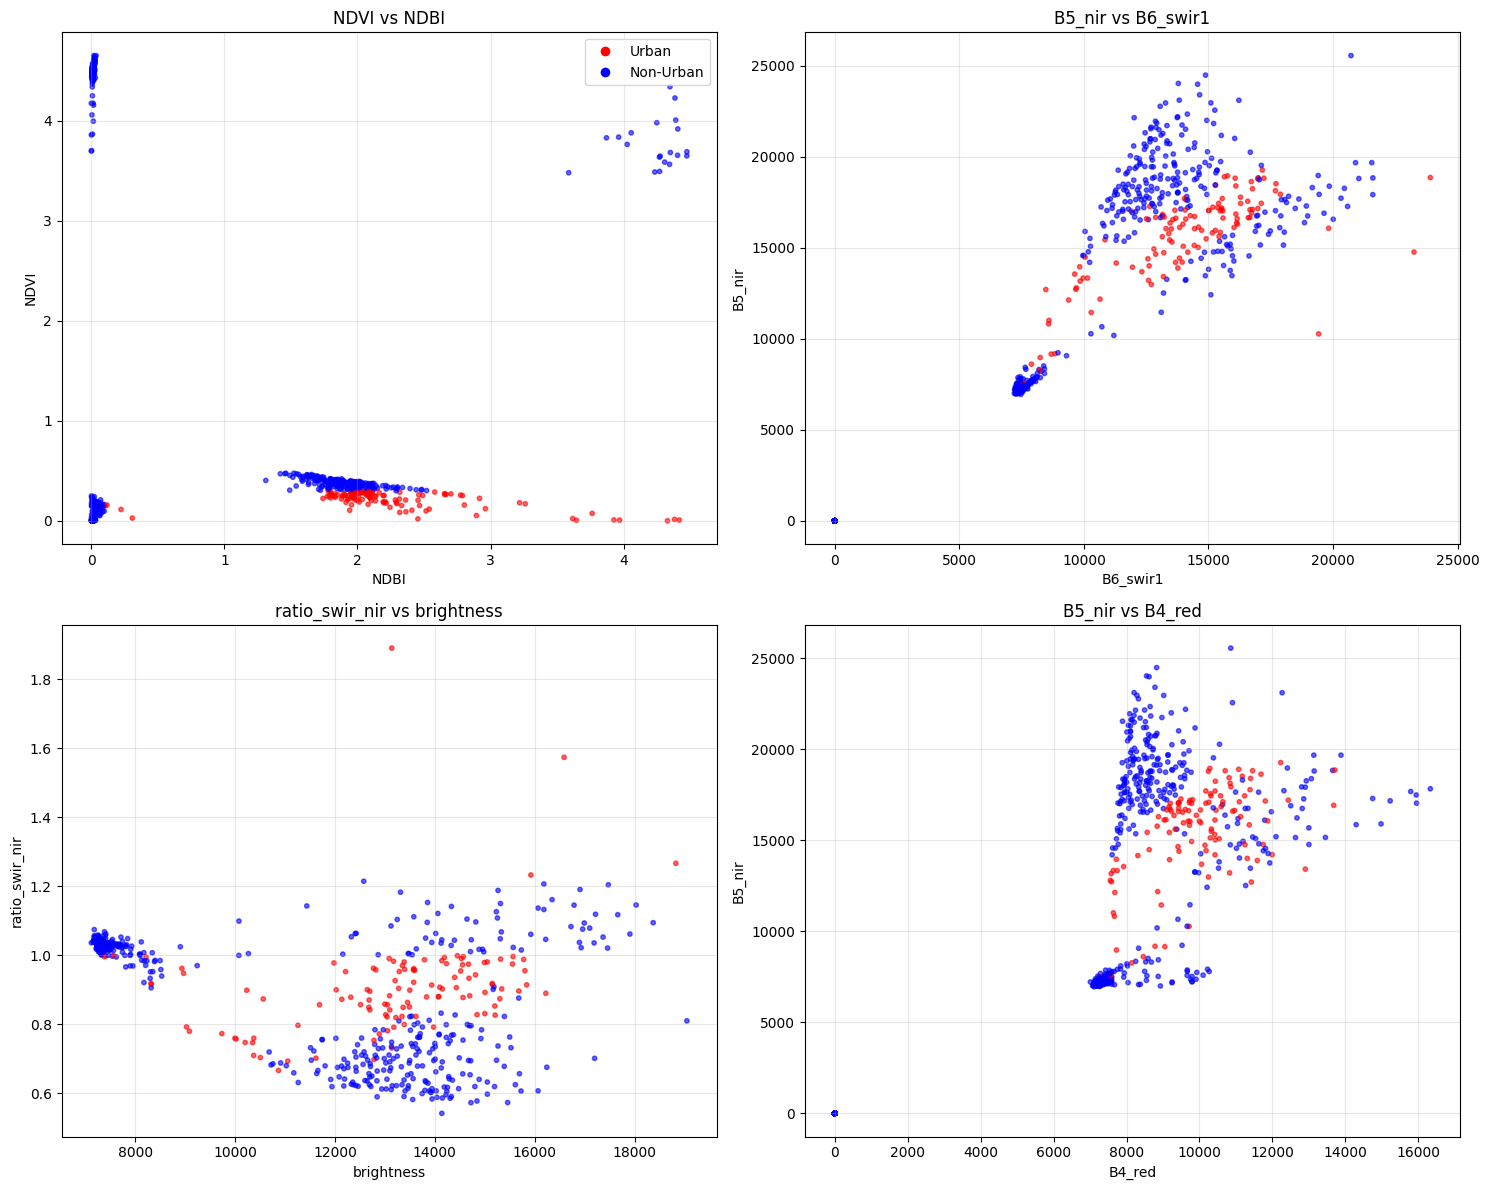

In [28]:
# Create scatter plots to see class separation
plot_pairs = [
    ('NDBI', 'NDVI'),
    ('B6_swir1', 'B5_nir'),
    ('brightness', 'ratio_swir_nir'),
    ('B4_red', 'B5_nir')
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (x_feat, y_feat) in enumerate(plot_pairs):
    # Sample for better visualization
    sample_df = df.sample(1000, random_state=42) if len(df) > 1000 else df

    scatter = axes[i].scatter(sample_df[x_feat], sample_df[y_feat],
                             c=sample_df['is_urban'], cmap='bwr', alpha=0.6, s=10)
    axes[i].set_xlabel(x_feat)
    axes[i].set_ylabel(y_feat)
    axes[i].set_title(f'{y_feat} vs {x_feat}')
    axes[i].grid(True, alpha=0.3)

    # Add legend
    if i == 0:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Urban'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Non-Urban')]
        axes[i].legend(handles=handles)

plt.tight_layout()
#plt.savefig("Class Separation.png")
plt.show()

/tmp/ipython-input-3880040006.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  urban_proportion = df_binned.groupby('feature_bin')['is_urban'].mean()
/tmp/ipython-input-3880040006.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  urban_proportion = df_binned.groupby('feature_bin')['is_urban'].mean()
/tmp/ipython-input-3880040006.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  urban_proportion = df_binned.grou

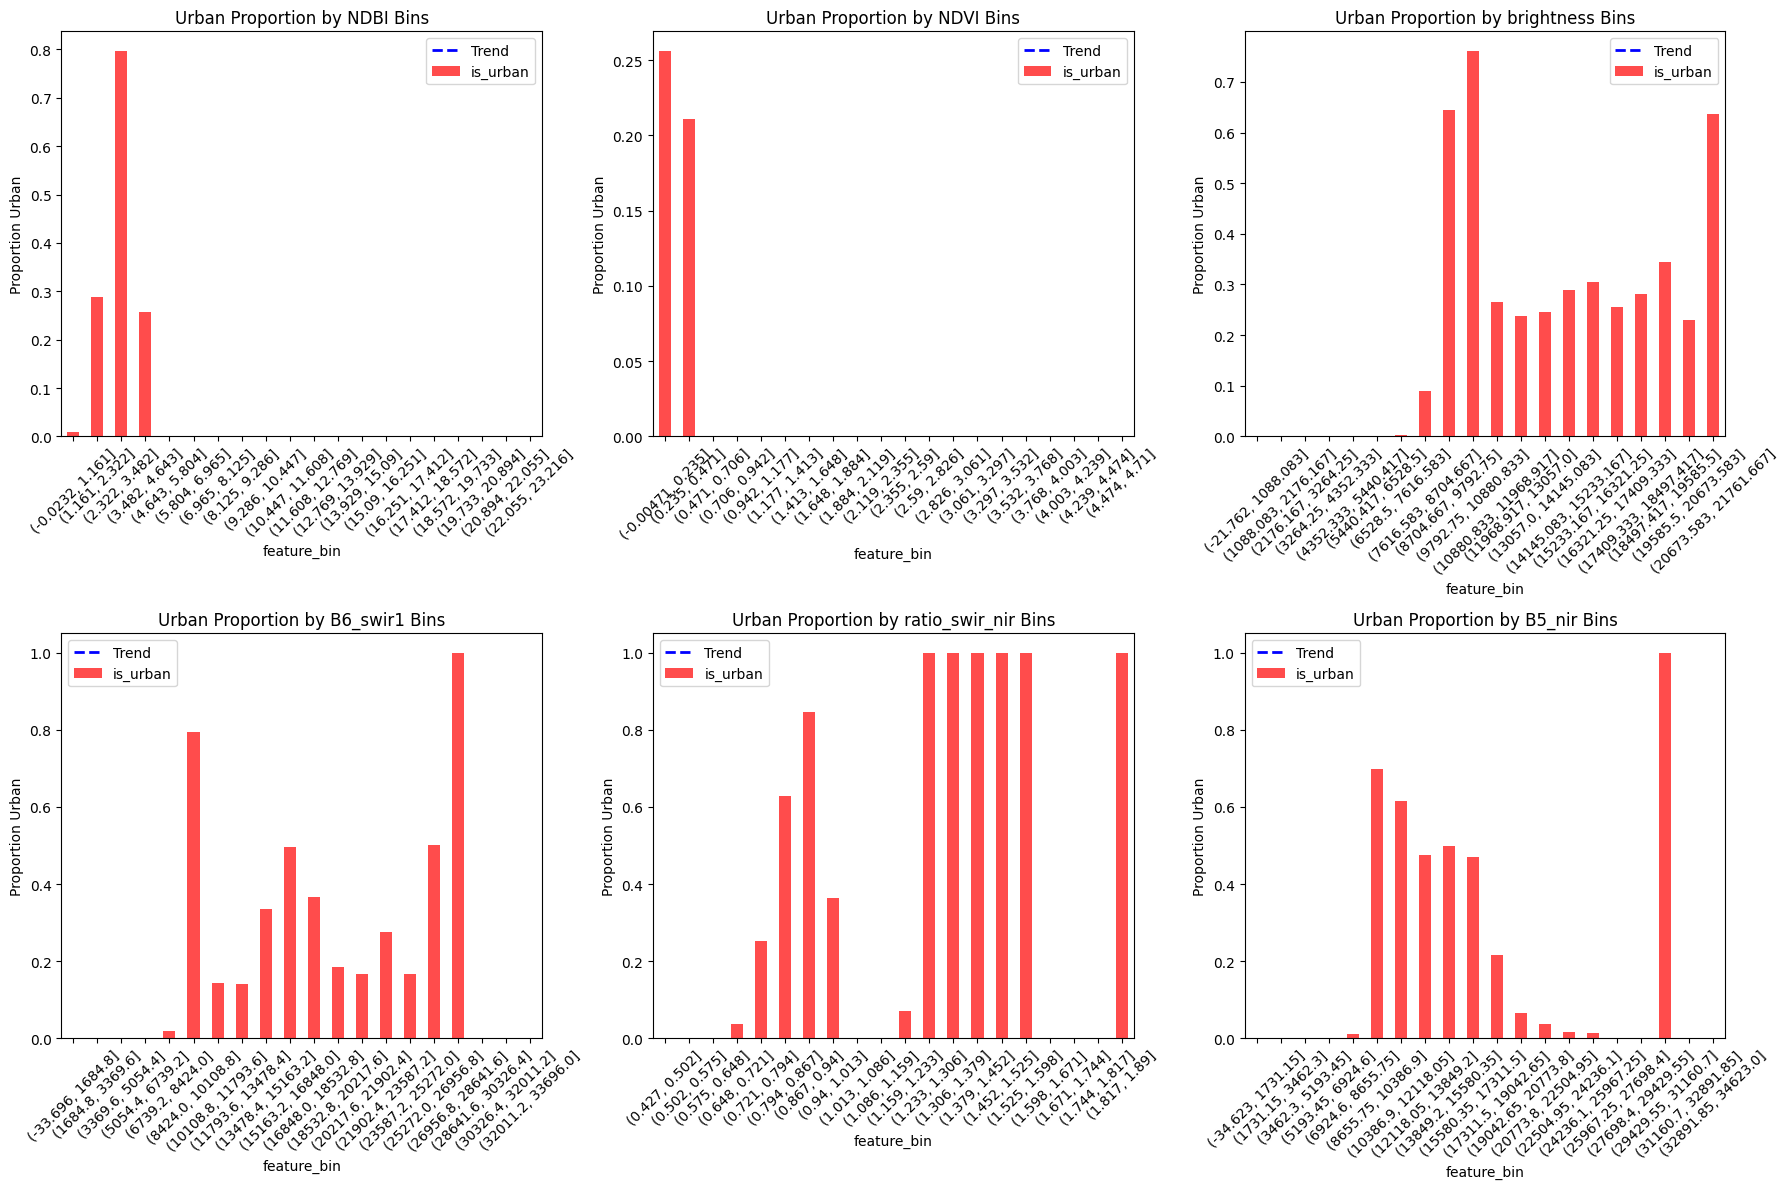

In [31]:
# Analyze how urban classification changes with feature values
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

features_to_bin = ['NDBI', 'NDVI', 'brightness', 'B6_swir1', 'ratio_swir_nir', 'B5_nir']

for i, feature in enumerate(features_to_bin):
    ax = axes[i//3, i%3]

    # Bin the feature and calculate urban proportion in each bin
    df_binned = df.copy()
    df_binned['feature_bin'] = pd.cut(df[feature], bins=20)
    urban_proportion = df_binned.groupby('feature_bin')['is_urban'].mean()

    # Plot
    urban_proportion.plot(kind='bar', ax=ax, color='red', alpha=0.7)
    ax.set_title(f'Urban Proportion by {feature} Bins')
    ax.set_ylabel('Proportion Urban')
    ax.tick_params(axis='x', rotation=45)

    # Add a trend line
    x_positions = np.arange(len(urban_proportion))
    z = np.polyfit(x_positions, urban_proportion.values, 1)
    p = np.poly1d(z)
    ax.plot(x_positions, p(x_positions), "b--", linewidth=2, label='Trend')
    ax.legend()

plt.tight_layout()
#plt.savefig("Urban Proportion by Feature Bins.png")
plt.show()

In [34]:
# Sample for better performance
sample_df = df.sample(1000, random_state=42) if len(df) > 1000 else df

fig = px.scatter_3d(sample_df, x='NDBI', y='NDVI', z='brightness',
                       color='is_urban', opacity=0.7,
                       color_continuous_scale='viridis',
                       title='3D Feature Space: NDBI vs NDVI vs Brightness')
fig.show()

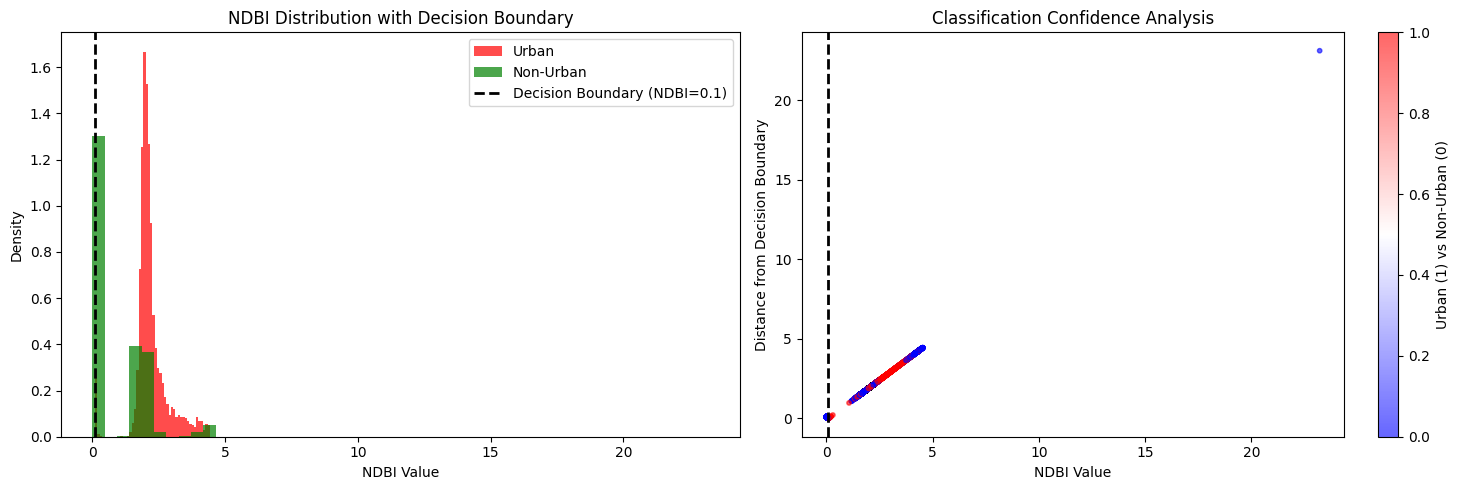

In [35]:
# Analyze where the classification is most certain/uncertain
plt.figure(figsize=(15, 5))

# 1. NDBI values with classification confidence bands
plt.subplot(1, 2, 1)
urban_ndbi = df[df['is_urban'] == 1]['NDBI']
non_urban_ndbi = df[df['is_urban'] == 0]['NDBI']

plt.hist(urban_ndbi, bins=50, alpha=0.7, color='red', label='Urban', density=True)
plt.hist(non_urban_ndbi, bins=50, alpha=0.7, color='green', label='Non-Urban', density=True)

# Add decision boundary
plt.axvline(x=0.1, color='black', linestyle='--', linewidth=2, label='Decision Boundary (NDBI=0.1)')
plt.xlabel('NDBI Value')
plt.ylabel('Density')
plt.title('NDBI Distribution with Decision Boundary')
#plt.savefig("NDBI Distribution Decision Boundary.png")
plt.legend()

# 2. Classification confidence analysis
plt.subplot(1, 2, 2)
# Calculate distance from decision boundary
df['distance_from_boundary'] = abs(df['NDBI'] - 0.1)

# Plot confidence vs feature values
plt.scatter(df['NDBI'], df['distance_from_boundary'],
           c=df['is_urban'], cmap='bwr', alpha=0.6, s=10)
plt.axvline(x=0.1, color='black', linestyle='--', linewidth=2)
plt.xlabel('NDBI Value')
plt.ylabel('Distance from Decision Boundary')
plt.title('Classification Confidence Analysis')
plt.colorbar(label='Urban (1) vs Non-Urban (0)')
#plt.savefig("Classification Confidence Analysis.png")
plt.tight_layout()
plt.show()

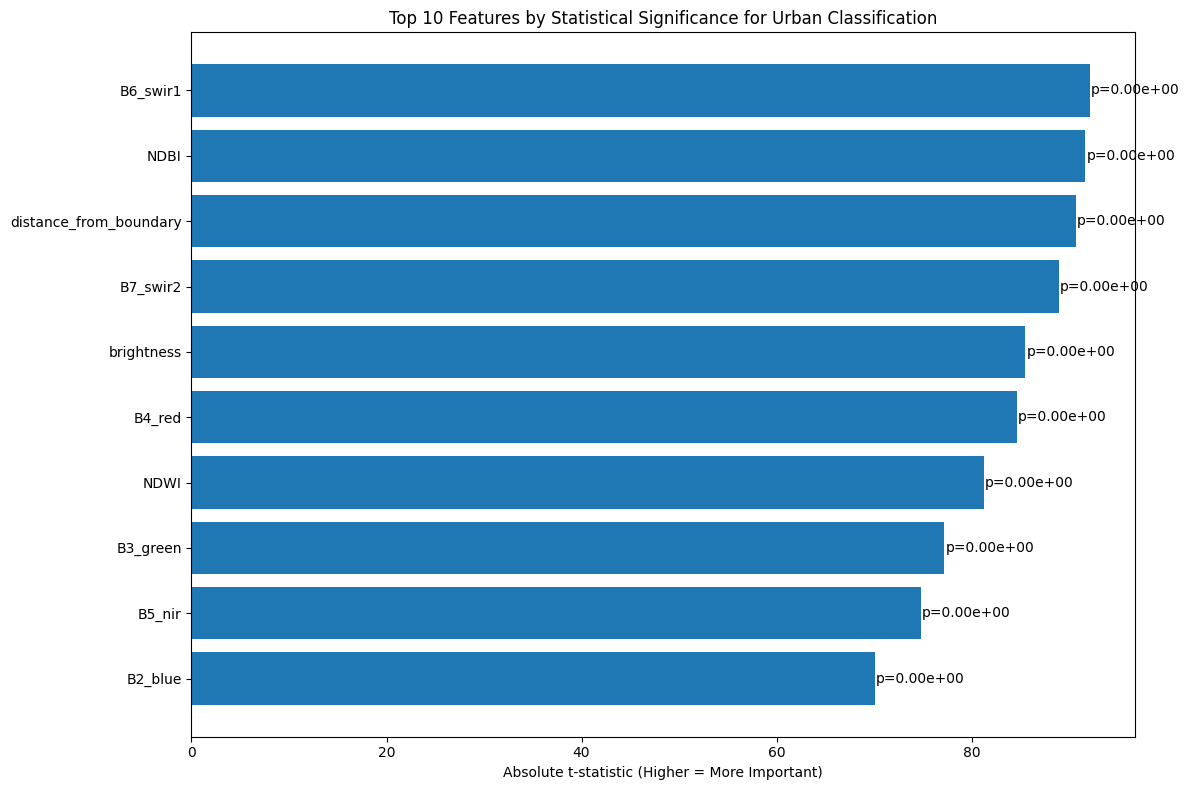

In [38]:
#Doing this shit to have statistical testing before modellig to know what we have to do
# Calculate t-test importance for each feature
feature_importance_preview = {}
for feature in df.columns:
    if feature not in ['is_urban'] and df[feature].dtype in [np.int64, np.float64]:
        urban_values = df[df['is_urban'] == 1][feature].dropna()
        non_urban_values = df[df['is_urban'] == 0][feature].dropna()

        if len(urban_values) > 1 and len(non_urban_values) > 1:
            t_stat, p_value = stats.ttest_ind(urban_values, non_urban_values)
            feature_importance_preview[feature] = {
                't_statistic': abs(t_stat),
                'p_value': p_value,
                'mean_diff': urban_values.mean() - non_urban_values.mean()
            }

# Create DataFrame and sort by importance
importance_df = pd.DataFrame(feature_importance_preview).T
importance_df = importance_df.sort_values('t_statistic', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df.index[:10], importance_df['t_statistic'][:10])
plt.xlabel('Absolute t-statistic (Higher = More Important)')
plt.title('Top 10 Features by Statistical Significance for Urban Classification')
plt.gca().invert_yaxis()

# Add p-value annotations
for i, (idx, row) in enumerate(importance_df.head(10).iterrows()):
    plt.text(row['t_statistic'] + 0.1, i, f'p={row["p_value"]:.2e}', va='center')

plt.tight_layout()
#plt.savefig("Top 10 Features by Statistical Significance for Urban Classification.png")
plt.show()

In [40]:
#Feature Engineering and Data Preprocessing
def smart_imputation(X):
    """
    Smart imputation strategy based on feature characteristics
    """
    X_imputed = X.copy()

    # Identify feature types
    spectral_bands = [col for col in X.columns if col.startswith('B') and len(col) == 6]
    indices = [col for col in X.columns if col in ['NDVI', 'NDBI', 'NDWI', 'SAVI', 'UI', 'EBBI', 'IBI']]
    ratios = [col for col in X.columns if 'ratio' in col or 'div' in col]
    other_features = [col for col in X.columns if col not in spectral_bands + indices + ratios]

    # Different imputation strategies
    imputers = {
        'spectral': SimpleImputer(strategy='median'),
        'indices': SimpleImputer(strategy='mean'),
        'ratios': SimpleImputer(strategy='median'),
        'other': SimpleImputer(strategy='most_frequent')
    }

    # Apply imputation
    for feature_type, features in [('spectral', spectral_bands),
                                  ('indices', indices),
                                  ('ratios', ratios),
                                  ('other', other_features)]:
        if features:
            imputer = imputers[feature_type]
            X_imputed[features] = imputer.fit_transform(X[features])

    return X_imputed

In [41]:
def create_advanced_features(X):
    """
    Create advanced features for urban expansion prediction
    """
    X_advanced = X.copy()

    # 1. Basic Spectral Indices (if not already present)
    if all(col in X.columns for col in ['B4_red', 'B5_nir', 'B6_swir1', 'B3_green']):
        # Urban-specific indices
        X_advanced['UI'] = (X['B6_swir1'] - X['B5_nir']) / (X['B6_swir1'] + X['B5_nir'])  # Urban Index
        X_advanced['EBBI'] = (X['B6_swir1'] - X['B5_nir']) / (X['B6_swir1'] + X['B5_nir'] + X['B4_red'])  # Enhanced Built-up Index
        X_advanced['IBI'] = (2 * X['B6_swir1'] / (X['B6_swir1'] + X['B5_nir']) -
                            (X['B5_nir'] / (X['B5_nir'] + X['B4_red']) +
                             X['B4_red'] / (X['B4_red'] + X['B3_green']))) / \
                           (2 * X['B6_swir1'] / (X['B6_swir1'] + X['B5_nir']) +
                            (X['B5_nir'] / (X['B5_nir'] + X['B4_red']) +
                             X['B4_red'] / (X['B4_red'] + X['B3_green'])))  # Index-based Built-up Index

    # 2. Band Ratios and Combinations
    band_combinations = {
        'ratio_swir2_nir': 'B7_swir2 / B5_nir',
        'ratio_red_blue': 'B4_red / B2_blue',
        'ratio_green_blue': 'B3_green / B2_blue',
        'ratio_swir1_blue': 'B6_swir1 / B2_blue',
        'sum_swir_bands': 'B6_swir1 + B7_swir2',
        'diff_nir_red': 'B5_nir - B4_red',
        'brightness_index': '(B4_red + B5_nir + B6_swir1) / 3'
    }

    for new_feat, expression in band_combinations.items():
        try:
            X_advanced[new_feat] = X.eval(expression)
        except:
            pass

    # 3. Statistical Features (if we have spatial context)
    if 'row' in X.columns and 'col' in X.columns:
        # Create neighborhood statistics (simplified)
        for band in ['B5_nir', 'B6_swir1', 'NDBI', 'NDVI']:
            if band in X.columns:
                X_advanced[f'{band}_neighbor_mean'] = X[band].rolling(window=100, center=True).mean().fillna(X[band].mean())
                X_advanced[f'{band}_neighbor_std'] = X[band].rolling(window=100, center=True).std().fillna(X[band].std())

    # 4. Interaction Features
    interaction_pairs = [
        ('NDBI', 'NDVI'),
        ('B6_swir1', 'B5_nir'),
        ('brightness', 'ratio_swir_nir')
    ]

    for feat1, feat2 in interaction_pairs:
        if feat1 in X.columns and feat2 in X.columns:
            X_advanced[f'{feat1}_x_{feat2}'] = X[feat1] * X[feat2]
            X_advanced[f'{feat1}_div_{feat2}'] = X[feat1] / X[feat2].replace(0, np.nan)

    # 5. Polynomial Features (for non-linear relationships)
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    main_features = ['NDBI', 'NDVI', 'B6_swir1', 'B5_nir']
    main_features = [f for f in main_features if f in X.columns]

    if main_features:
        poly_features = poly.fit_transform(X[main_features].fillna(X[main_features].mean()))
        poly_feature_names = poly.get_feature_names_out(main_features)
        poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=X.index)
        X_advanced = pd.concat([X_advanced, poly_df], axis=1)

    # 6. Log Transformations for skewed features
    skewed_features = ['B6_swir1', 'B5_nir', 'B4_red', 'brightness']
    for feat in skewed_features:
        if feat in X.columns:
            X_advanced[f'log_{feat}'] = np.log1p(X[feat].clip(lower=0))

    return X_advanced

In [43]:
df = create_advanced_features(smart_imputation(df))

In [45]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42) # probability=True for ROC curve
}

param_grids = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l2'] # l1, elasticnet require solver='liblinear' or 'saga'
    },
    'RandomForestClassifier': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'DecisionTreeClassifier': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'KNeighborsClassifier': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2] # 1 for Manhattan, 2 for Euclidean
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto', 0.1, 1],
        'model__kernel': ['rbf', 'linear']
    }
}

In [51]:
# Check and handle infinite and very large values
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        # Replace infinite values with NaN
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

        # Check for very large values and clip them
        max_float = np.finfo(np.float64).max
        df[col] = np.clip(df[col], -max_float, max_float)

# Impute remaining NaN values using the mean strategy
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [52]:
# Check and handle infinite and very large values
for col in df.columns:
    # Check if the column is of a numeric dtype
    if pd.api.types.is_numeric_dtype(df[col]):
        # Replace infinite values with NaN
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

        # Check for very large values and clip them
        max_float = np.finfo(np.float64).max
        df[col] = np.clip(df[col], -max_float, max_float)

# Impute remaining NaN values using the mean strategy
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [53]:
grid_search_results = {}

for model_name, model in models.items():
    print(f"Running Randomized Search for {model_name}...")

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])

    # Get the parameter grid for the current model
    param_grid = param_grids[model_name]

    # Create RandomizedSearchCV object
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

    # Fit RandomizedSearchCV to the training data
    grid_search.fit(X_train, Y_train)

    # Store the results
    grid_search_results[model_name] = grid_search

    print(f"Finished Randomized Search for {model_name}.")

print("All Randomized Searches completed.")

Running Randomized Search for LogisticRegression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.



ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py", line 1624, in fit
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float64').


In [54]:
# Check and handle infinite and very large values again after feature engineering
for col in df.columns:
    # Check if the column is of a numeric dtype
    if pd.api.types.is_numeric_dtype(df[col]):
        # Replace infinite values with NaN
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

        # Check for very large values and clip them
        max_float = np.finfo(np.float64).max
        df[col] = np.clip(df[col], -max_float, max_float)

# Impute remaining NaN values using the mean strategy
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Re-split the data to ensure X_train and Y_train are defined with the cleaned data
X = df.drop("is_urban", axis=1)
y = df["is_urban"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

grid_search_results = {}

for model_name, model in models.items():
    print(f"Running Randomized Search for {model_name}...")

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])

    # Get the parameter grid for the current model
    param_grid = param_grids[model_name]

    # Create RandomizedSearchCV object
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

    # Fit RandomizedSearchCV to the training data
    grid_search.fit(X_train, Y_train)

    # Store the results
    grid_search_results[model_name] = grid_search

    print(f"Finished Randomized Search for {model_name}.")

print("All Randomized Searches completed.")

Running Randomized Search for LogisticRegression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.



Finished Randomized Search for LogisticRegression.
Running Randomized Search for RandomForestClassifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Finished Randomized Search for RandomForestClassifier.
Running Randomized Search for DecisionTreeClassifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Finished Randomized Search for DecisionTreeClassifier.
Running Randomized Search for KNeighborsClassifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Finished Randomized Search for KNeighborsClassifier.
Running Randomized Search for SVC...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Finished Randomized Search for SVC.
All Randomized Searches completed.


In [55]:
best_model = None
best_score = -1
best_params = None
overall_best_model_name = None

print("Randomized Search Results:")
for model_name, grid_search in grid_search_results.items():
    print(f"\n--- {model_name} ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        overall_best_model_name = model_name

print("\n--- Overall Best Model ---")
print(f"Model: {overall_best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation F1 Score: {best_score:.4f}")

Randomized Search Results:

--- LogisticRegression ---
Best Parameters: {'model__penalty': 'l2', 'model__C': 100}
Best Cross-Validation F1 Score: 0.9879

--- RandomForestClassifier ---
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best Cross-Validation F1 Score: 0.9993

--- DecisionTreeClassifier ---
Best Parameters: {'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 30}
Best Cross-Validation F1 Score: 0.9960

--- KNeighborsClassifier ---
Best Parameters: {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 9}
Best Cross-Validation F1 Score: 0.9811

--- SVC ---
Best Parameters: {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 1}
Best Cross-Validation F1 Score: 0.9815

--- Overall Best Model ---
Model: RandomForestClassifier
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 2

## Summary:

### Data Analysis Key Findings

*   Data cleaning steps were successfully performed to handle infinite and very large values and impute missing data using the mean strategy.
*   Randomized Search with 5-fold cross-validation was successfully executed for Logistic Regression, Random Forest, Decision Tree, K-Nearest Neighbors, and Support Vector Classifier models using F1 score as the evaluation metric.
*   The best cross-validation F1 scores for each model were: Logistic Regression (0.9879), Random Forest Classifier (0.9993), Decision Tree Classifier (0.9960), K-Nearest Neighbors Classifier (0.9811), and SVC (0.9815).
*   The RandomForestClassifier achieved the highest cross-validation F1 score of 0.9993.

### Insights or Next Steps

*   The RandomForestClassifier is the best performing model among those tested, based on the cross-validation F1 score.
*   The next step could involve evaluating the overall best model (RandomForestClassifier) on the held-out test set to get a final performance estimate.


In [56]:
#Data Modelling time
X = df.drop("is_urban", axis=1)
y = df["is_urban"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=20)
pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
])

pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=200))])

Basic Metrics:
Accuracy:  0.9996
Precision: 0.9965
Recall:    1.0000
F1-Score:  0.9982

Confusion Matrix:
True Non-Urban (TN): 8861 | False Urban (FP): 4
False Non-Urban (FN): 0 | True Urban (TP): 1135


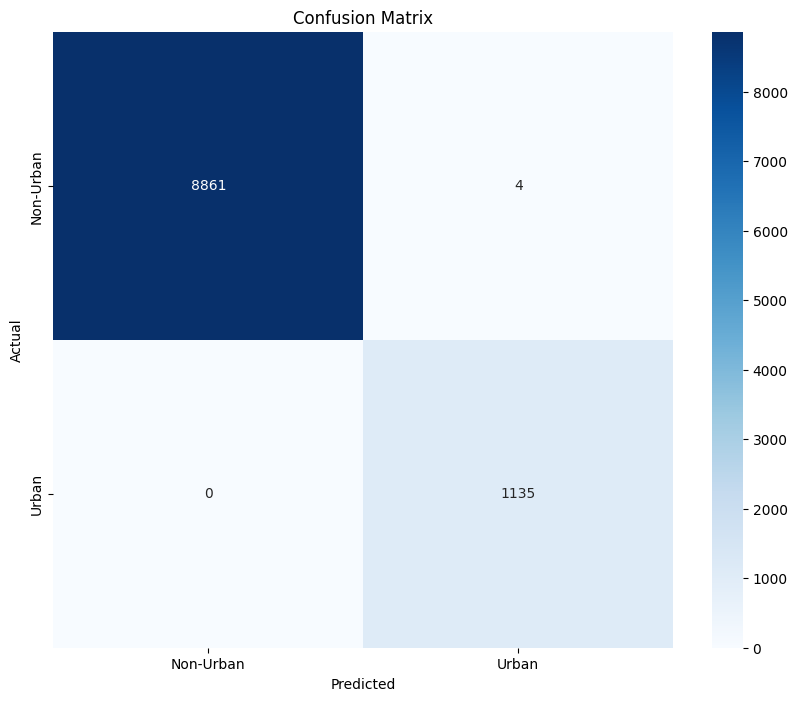

In [59]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print("Basic Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"True Non-Urban (TN): {tn} | False Urban (FP): {fp}")
print(f"False Non-Urban (FN): {fn} | True Urban (TP): {tp}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Urban', 'Urban'],
            yticklabels=['Non-Urban', 'Urban'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.savefig("Confusion Matrix.png")
plt.show()

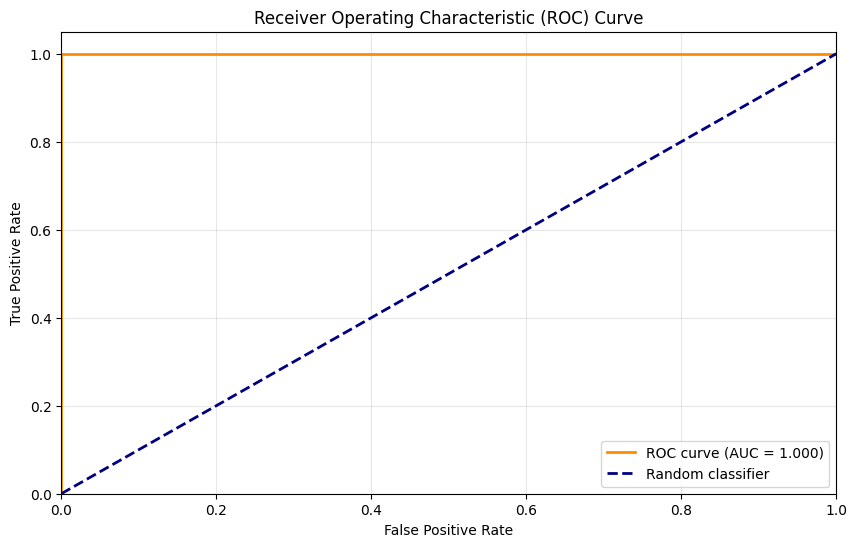

ROC-AUC Score: 1.0000


In [61]:
#roc-curve curve, auc computation
# Get predicted probabilities for class 1 (Urban)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
#plt.savefig("ROC-AUC Score.png")
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

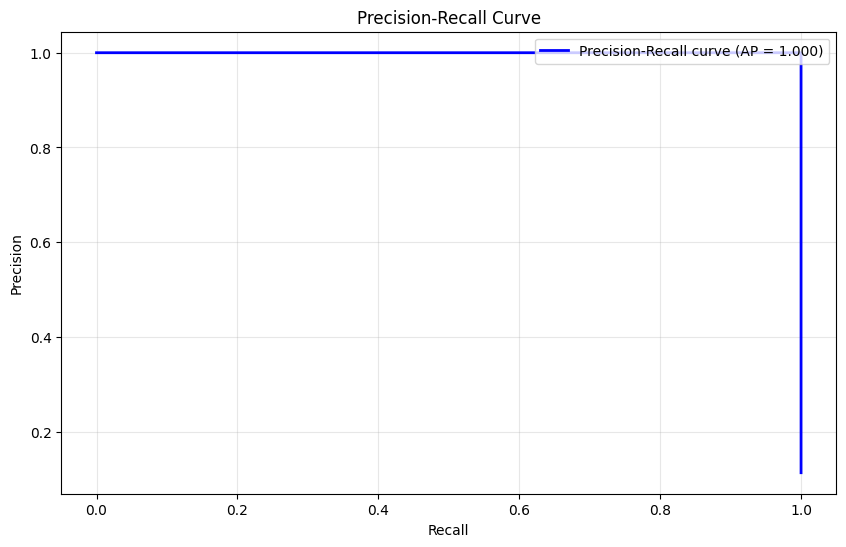

In [63]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, _ = precision_recall_curve(Y_test, y_pred_proba)
avg_precision = average_precision_score(Y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
#plt.savefig("Precision-Recall Curve.png")
plt.show()

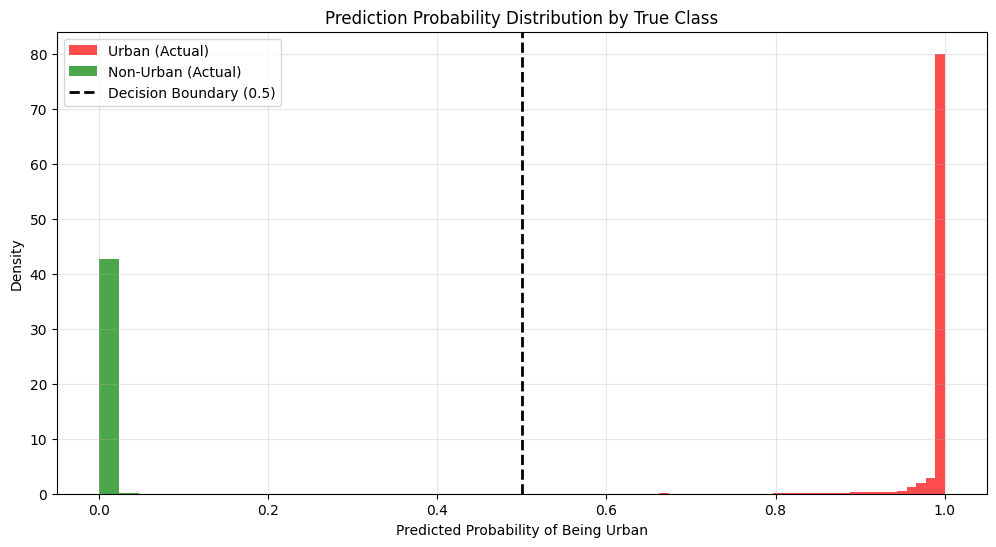

In [65]:
#Probability Distribution Plot
urban_probs = y_pred_proba[Y_test == 1]
non_urban_probs = y_pred_proba[Y_test == 0]

plt.figure(figsize=(12, 6))
plt.hist(urban_probs, bins=30, alpha=0.7, color='red', label='Urban (Actual)', density=True)
plt.hist(non_urban_probs, bins=30, alpha=0.7, color='green', label='Non-Urban (Actual)', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Boundary (0.5)')
plt.xlabel('Predicted Probability of Being Urban')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution by True Class')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig("Prediction Probability Distribution by True Class.png")
plt.show()

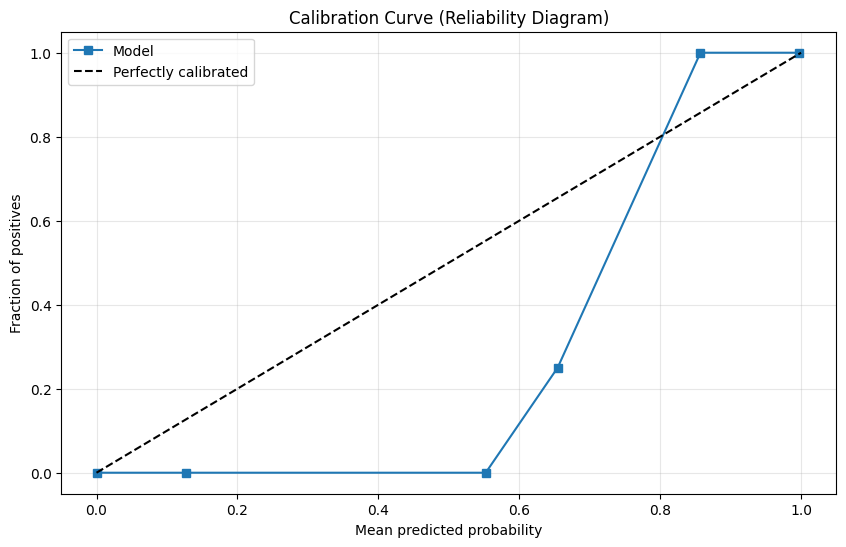

In [67]:
# Calibration Curve
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(Y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig("Calibration Curve.png")
plt.show()

In [71]:
# Error Analysis
error_mask = Y_test != y_pred
error_count = error_mask.sum()
total_count = len(Y_test)

print(f"\n🔍 Error Analysis:")
print(f"Total errors: {error_count}/{total_count} ({error_count/total_count:.2%})")

# False positives vs false negatives
false_urban = ((Y_test == 0) & (y_pred == 1)).sum()
false_non_urban = ((Y_test == 1) & (y_pred == 0)).sum()

print(f"False Urban (Type I): {false_urban} ({false_urban/error_count:.2%} of errors)")
print(f"False Non-Urban (Type II): {false_non_urban} ({false_non_urban/error_count:.2%} of errors)")

# Analyze feature values for errors
if error_count > 0:
    error_indices = error_mask[error_mask].index
    correct_indices = error_mask[~error_mask].index

    # Compare mean feature values
    error_features = X_test.loc[error_indices].mean()
    correct_features = X_test.loc[correct_indices].mean()

    feature_diff = (error_features - correct_features).abs().sort_values(ascending=False)

    print(f"\n📊 Features with largest difference between correct and incorrect predictions:")
    for feature, diff in feature_diff.head(5).items():
        print(f"  {feature}: {diff:.4f}")


🔍 Error Analysis:
Total errors: 4/10000 (0.04%)
False Urban (Type I): 4 (100.00% of errors)
False Non-Urban (Type II): 0 (0.00% of errors)

📊 Features with largest difference between correct and incorrect predictions:
  B6_swir1 B5_nir: 352299512.7556
  B6_swir1_x_B5_nir: 352299512.7556
  NDBI B6_swir1: 22155.1643
  sum_swir_bands: 21736.7331
  NDBI B5_nir: 21316.2621


In [72]:
# Final Summary
print("=" * 60)
print("🎯 URBAN EXPANSION PREDICTION MODEL - FINAL REPORT")
print("=" * 60)

print(f"\n📈 PERFORMANCE SUMMARY:")
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}  (Urban prediction reliability)")
print(f"Recall:     {recall:.4f}    (Urban detection rate)")
print(f"F1-Score:   {f1:.4f}    (Balance between precision and recall)")
print(f"ROC-AUC:    {roc_auc:.4f}   (Overall classification ability)")

print(f"\n🔍 ERROR ANALYSIS:")
print(f"Total errors:      {error_count}/{total_count} ({error_count/total_count:.2%})")
print(f"False Urban:       {false_urban} (Non-urban areas predicted as urban)")
print(f"False Non-Urban:   {false_non_urban} (Urban areas predicted as non-urban)")

print(f"\n💡 RECOMMENDATIONS:")
if f1 > 0.8:
    print("✓ Excellent model performance - ready for deployment")
elif f1 > 0.6:
    print("✓ Good model performance - consider minor improvements")
else:
    print("⚠ Model needs improvement - review feature engineering")

if false_urban > false_non_urban * 2:
    print("⚠ High false urban rate - consider increasing classification threshold")
elif false_non_urban > false_urban * 2:
    print("⚠ High false non-urban rate - consider decreasing classification threshold")

print("=" * 60)

🎯 URBAN EXPANSION PREDICTION MODEL - FINAL REPORT

📈 PERFORMANCE SUMMARY:
Accuracy:   0.9996
Precision:  0.9965  (Urban prediction reliability)
Recall:     1.0000    (Urban detection rate)
F1-Score:   0.9982    (Balance between precision and recall)
ROC-AUC:    1.0000   (Overall classification ability)

🔍 ERROR ANALYSIS:
Total errors:      4/10000 (0.04%)
False Urban:       4 (Non-urban areas predicted as urban)
False Non-Urban:   0 (Urban areas predicted as non-urban)

💡 RECOMMENDATIONS:
✓ Excellent model performance - ready for deployment
⚠ High false urban rate - consider increasing classification threshold


In [73]:
#ok, lets outsource to pickle
with open("model.pkl", "wb") as ml:
    pickle.dump(pipeline, ml)